##  Data Cleaning   - Worked By Emilia Roberts

In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json

In [2]:
# Name of the CSV file
obesity_file = Path('../Resources/500_Cities__Obesity_among_adults_aged___18_years_20231109.csv')
walk_file = Path('../Resources/EPA_SmartLocationDatabase_V3_Jan_2021_Final (1).csv')
income_file = Path('../Resources/kaggle_income.csv')
weather_file = Path('../Resources/56_Major_City_Weather_Data.csv')

In [3]:
# The correct encoding must be used to read the CSV in pandas
obesity_df = pd.read_csv(obesity_file, encoding="ISO-8859-1")
walk_df = pd.read_csv(walk_file, encoding="ISO-8859-1")
income_df = pd.read_csv(income_file, encoding="ISO-8859-1")
weather_df = pd.read_csv(weather_file, encoding="ISO-8859-1")

In [4]:
#cleaning and grouping of income by city name
cleaned_income_df = income_df.drop(['id', 'Type', 'Primary', 
                                     'Area_Code','ALand','AWater',
                                     'Lat','Lon','sum_w'], axis=1)
city_income_df = cleaned_income_df.groupby('City', as_index = False)['Mean'].mean()
city_income_df.head()

,City,Mean
0,Abbeville,38459.428571
1,Abbotsford,58254.000000
2,Aberdeen,68306.500000
3,Abilene,51441.866667
4,Abingdon,85714.166667


In [5]:
#cleaning obesity df to make more readable
cleaned_obesity_df = obesity_df.drop(['GeographicLevel', 'DataSource', 'Category', 
                                      'UniqueID','Measure','Data_Value_Unit',
                                      'DataValueTypeID','Data_Value_Type','Data_Value_Footnote_Symbol',
                                      'Data_Value_Footnote','CategoryID','MeasureId','Short_Question_Text'], axis=1)

#grouping by city to remove duplicate values (limitation on not doing it by zipcode)
city_obesity_df = cleaned_obesity_df.groupby('CityName', as_index = False)['Data_Value'].mean()
city_obesity_df.head()

,CityName,Data_Value
0,Abilene,33.838462
1,Akron,38.142647
2,Alameda,20.338889
3,Albany,35.403636
4,Albuquerque,26.787050


In [6]:
#Generation of dataframe with lat/long values
city_loc_df = obesity_df.drop(['GeographicLevel', 'DataSource', 'Category', 
                                      'UniqueID','Measure','Data_Value_Unit',
                                      'DataValueTypeID','Data_Value_Type','Data_Value_Footnote_Symbol',
                                      'Data_Value_Footnote','CategoryID','MeasureId','Short_Question_Text',
                              'StateDesc', 'Data_Value', 'Low_Confidence_Limit','High_Confidence_Limit',
                              'PopulationCount','CityFIPS','TractFIPS','ï»¿Year'], axis=1)

#split geolocation column into two and then drop it
#also removing special characters and converting lat and long to floats
city_loc_df[['Lat','Lon']] = city_loc_df['GeoLocation'].str.split(',',expand=True)
city_loc_df = city_loc_df.drop(['GeoLocation'], axis=1)


city_loc_df['Lat'] = city_loc_df['Lat'].str.replace('(', '')
city_loc_df['Lon'] = city_loc_df['Lon'].str.replace(')', '')
city_loc_df[['Lat','Lon']] = city_loc_df[['Lat','Lon']].astype(float)

city_loc_df_g = city_loc_df.groupby('CityName', as_index = False)['Lat'].mean()

city_loc_df_lat = city_loc_df.groupby('CityName', as_index = False)['Lat'].mean()
city_loc_df_lon = city_loc_df.groupby('CityName', as_index = False)['Lon'].mean()
city_loc_df = pd.merge(city_loc_df_lat, city_loc_df_lon, left_on='CityName', right_on='CityName', how='inner')

city_loc_df.head()

,CityName,Lat,Lon
0,Abilene,32.450916,-99.748149
1,Akron,41.076997,-81.521454
2,Alameda,37.764098,-122.260090
3,Albany,37.219589,-78.884677
4,Albuquerque,35.112121,-106.612063


In [7]:
#cleaning of weather dataframe to remove columns we dont want
weather_df = weather_df[['City','Avg_High_Temp_F','Avg_Low_Temp_F']]
weather_df.head()

,City,Avg_High_Temp_F,Avg_Low_Temp_F
0,"Atlanta, Georgia",73,54
1,"Austin, Texas",81,59
2,"Baltimore, Maryland",67,46
3,"Birmingham, Alabama",74,54
4,"Boston, Massachusetts",59,45


In [8]:
#inner merge of city location and city obesity average %
#formatting to rename column names
loc_obe_merged_df = pd.merge(city_loc_df, city_obesity_df, left_on='CityName', right_on='CityName', how='inner')
loc_obe_merged_df = loc_obe_merged_df.rename(columns={"CityName": "City", "Data_Value": "Obesity %", "Mean": 'Average Income'})

loc_obe_merged_df.head()

,City,Lat,Lon,Obesity %
0,Abilene,32.450916,-99.748149,33.838462
1,Akron,41.076997,-81.521454,38.142647
2,Alameda,37.764098,-122.260090,20.338889
3,Albany,37.219589,-78.884677,35.403636
4,Albuquerque,35.112121,-106.612063,26.787050


In [9]:
#FINAL DATAFRAME
final_merge_df = pd.merge(city_income_df, loc_obe_merged_df, left_on='City', right_on='City', how='inner')
final_merge_df = final_merge_df.drop('Mean',axis=1)
final_merge_df

,City,Lat,Lon,Obesity %
0,Abilene,32.450916,-99.748149,33.838462
1,Akron,41.076997,-81.521454,38.142647
2,Alameda,37.764098,-122.260090,20.338889
3,Albany,37.219589,-78.884677,35.403636
4,Albuquerque,35.112121,-106.612063,26.787050
...,...,...,...,...
460,Wyoming,42.901075,-85.696571,33.362500
461,Yakima,46.593486,-120.537589,37.100000
462,Yonkers,40.939851,-73.870066,26.652830
463,Youngstown,41.094841,-80.652477,45.463636


#    Worked By: Elona Xhikola

## Income Data Analysis & Plotting                               

#### This section does all the necessary data analysis to find the correlation between Incoming and Obesity.

##### -The data used for all the further analyses are City Names, Geograficial position Latitude and Longtitude, Income Data and Obesity Rate.
##### -Income Data will serve as the key to do the categorization.
###### -Low Income, Medium Income, High Income and Very High Income will set some ranges which makes data more easy to check how the income impacts on Obesity.
###### -Latitude and Longtitude will help to create Map with Obesity Data according to the Income Classification.

In [10]:
#Here is a copy of the final DataFrame after the Cleaning Data which will be used to do all the analysis,
#to prevent any future errors with the primary table we create a copy DF.

final_merge_df = pd.merge(city_income_df, loc_obe_merged_df, left_on='City', right_on='City', how='inner')
Income_Analysis_df = final_merge_df.copy(deep = True)
Income_Analysis_df.head()

,City,Mean,Lat,Lon,Obesity %
0,Abilene,51441.866667,32.450916,-99.748149,33.838462
1,Akron,53194.675000,41.076997,-81.521454,38.142647
2,Alameda,89726.375000,37.764098,-122.260090,20.338889
3,Albany,52808.971429,37.219589,-78.884677,35.403636
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050


In [11]:
Income_Analysis_df.rename(columns={'Mean': 'Income Mean', 'Obesity %' : 'Obesity'}, inplace=True)
Income_Analysis_df
Income_Analysis_df.head()
#The column names are changed.

,City,Income Mean,Lat,Lon,Obesity
0,Abilene,51441.866667,32.450916,-99.748149,33.838462
1,Akron,53194.675000,41.076997,-81.521454,38.142647
2,Alameda,89726.375000,37.764098,-122.260090,20.338889
3,Albany,52808.971429,37.219589,-78.884677,35.403636
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050


# ----------------------------------------------------------------------------------

#### On this session I have created 4 Data Frames which Data are filter based on the Income Levels. These DataFrames help to retrieve Max, Mean and Min for each category.

#### 

In [12]:
# low Income Data Frame
filtered_Low = Income_Analysis_df[Income_Analysis_df['Income Mean'] < 50000]

LIncome_mean = filtered_Low['Obesity'].mean()
LIncome_max = filtered_Low['Obesity'].max()
LIncome_min = filtered_Low['Obesity'].min()

print('LIncome_mean',LIncome_mean)
print('LIncome_min', LIncome_min)
print('LIncome_max', LIncome_max)
filtered_Low.head()

LIncome_mean 36.363687019362516
LIncome_min 24.95
LIncome_max 50.04242424242425


,City,Income Mean,Lat,Lon,Obesity
26,Avondale,49653.000000,33.442091,-112.318168,31.082609
32,Beaumont,42865.315789,30.082328,-94.136981,39.622222
52,Brownsville,39989.714286,25.946678,-97.479697,42.034000
53,Bryan,46013.777778,30.663297,-96.360603,33.094444
55,Buffalo,46000.020000,42.909373,-78.849229,35.779012


In [13]:
# Medium Income Data Frame

filtered_Medium = Income_Analysis_df[(Income_Analysis_df['Income Mean'] >= 50000) & (Income_Analysis_df['Income Mean'] <= 80000)]

MIncome_mean = filtered_Medium ['Obesity'].mean()
MIncome_min = filtered_Medium ['Obesity'].min()
MIncome_max = filtered_Medium ['Obesity'].max()

print('MIncome_mean' , MIncome_mean)
print('MIncome_min ' ,MIncome_min)
print('MIncome_max' ,MIncome_max)

filtered_Medium.head()

MIncome_mean 30.78999225616328
MIncome_min  17.754545454545454
MIncome_max 42.96779661016949


,City,Income Mean,Lat,Lon,Obesity
0,Abilene,51441.866667,32.450916,-99.748149,33.838462
1,Akron,53194.675000,41.076997,-81.521454,38.142647
3,Albany,52808.971429,37.219589,-78.884677,35.403636
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050
6,Alhambra,75629.200000,34.084397,-118.135123,17.754545


In [14]:
# High Income Data Frame

filtered_High = Income_Analysis_df[(Income_Analysis_df['Income Mean'] >= 80000) & (Income_Analysis_df['Income Mean'] <= 100000)]

HIncome_mean = filtered_High ['Obesity'].mean()
HIncome_min = filtered_High ['Obesity'].min()
HIncome_max = filtered_High ['Obesity'].max()

print('HIncome_mean',HIncome_mean)
print('HIncome_min' , HIncome_min)
print('HIncome_max' ,HIncome_max)

filtered_High.head()

HIncome_mean 25.011890894726783
HIncome_min 15.383333333333333
HIncome_max 34.26315789473684


,City,Income Mean,Lat,Lon,Obesity
2,Alameda,89726.375000,37.764098,-122.260090,20.338889
5,Alexandria,92752.250000,38.818402,-77.088488,26.970000
7,Allen,89598.500000,33.101583,-96.660676,28.746154
11,Anchorage,89349.200000,61.185389,-149.752505,34.263158
14,Apple Valley,85965.363636,34.511436,-117.206269,31.264286


In [15]:
# Very High Income Data Frame

filtered_VHigh = Income_Analysis_df[Income_Analysis_df['Income Mean'] > 100000]

VHIncome_mean = filtered_VHigh['Obesity'].mean()
VHIncome_min = filtered_VHigh['Obesity'].min()
VHIncome_max = filtered_VHigh['Obesity'].max()

print('VHIncome_mean', VHIncome_mean)
print('VHIncome_min', VHIncome_min)
print('VHIncome', VHIncome_max)

filtered_VHigh.head()

VHIncome_mean 22.314082186229104
VHIncome_min 15.8
VHIncome 29.16


,City,Income Mean,Lat,Lon,Obesity
12,Ann Arbor,111892.937500,42.274588,-83.734149,26.520000
17,Arlington Heights,114682.750000,42.097889,-87.983531,24.266667
63,Carmel,112450.750000,39.970031,-86.132809,26.947059
66,Cary,114390.722222,35.784140,-78.817333,25.778049
68,Centennial,104362.666667,39.599520,-104.857480,21.575676


In [16]:
# After the calculation of the Min, Max, Mean for each category. The DataFrame below serves as summary table for all the data calculated above.

summary_df = pd.DataFrame({
    'Income_Group': ['Low_Income', 'Medium_Income', 'High_Income', 'VeryHigh_Income'],
    'Mean_Obesity': [LIncome_mean, MIncome_mean, HIncome_mean, VHIncome_mean],
    'Min_Obesity': [LIncome_min, MIncome_min, HIncome_min, VHIncome_min],
    'Max_Obesity': [LIncome_max, MIncome_max, HIncome_max , VHIncome_max]
   
})

#summary_df

summary_df_no_index = summary_df.set_index('Income_Group')
summary_df_no_index

,Mean_Obesity,Min_Obesity,Max_Obesity
Income_Group,,,
Low_Income,36.363687,24.950000,50.042424
Medium_Income,30.789992,17.754545,42.967797
High_Income,25.011891,15.383333,34.263158
VeryHigh_Income,22.314082,15.800000,29.160000


#### All tha data from the summary_df will be vizualize on the plot below:
##### The barchart clearly shows the correlation between the Income and Obesity. The Lower the Income the higher the Obesity and the higher the Income the lower the Obesity.




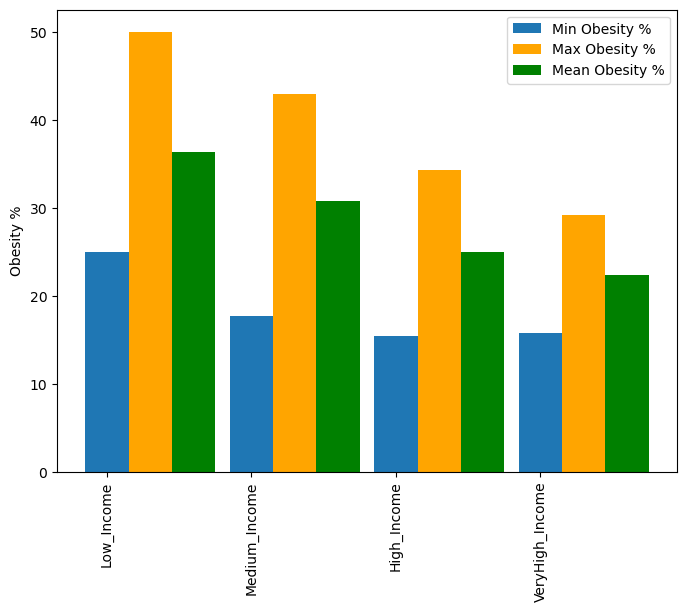

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 6))

width = 0.3
x = np.arange(len(summary_df['Income_Group']))

plt.xticks(x, summary_df['Income_Group'], rotation='vertical')

Obesity_min = ax1.bar(x, summary_df['Min_Obesity'], width)
Obesity_max = ax1.bar(x + width, summary_df['Max_Obesity'], width, color='orange')
Obesity_mean = ax1.bar(x + 2 * width, summary_df['Mean_Obesity'], width, color='green')

plt.ylabel('Obesity %')
plt.legend([Obesity_min, Obesity_max, Obesity_mean], ['Min Obesity %', 'Max Obesity %', 'Mean Obesity %'], loc='upper right')

fig.savefig('obesity_plot.png', bbox_inches='tight')

plt.show()


In [18]:
# Since I am having troubles with the column 'Income Mean' because of the space,I renamed this column for all the dataframes categorized by income. 
#I did a copy just to be sure to not affect the origina dataframe.

filtered_Low_copy = filtered_Low.copy()
filtered_Medium_copy = filtered_Medium.copy()
filtered_High_copy = filtered_High.copy()
filtered_VHigh_copy = filtered_VHigh.copy()

# Rename the 'Income Mean' column to 'Income_Mean' in the original DataFrames
filtered_Low_copy.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)
filtered_Medium_copy.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)
filtered_High_copy.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)
filtered_VHigh_copy.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)


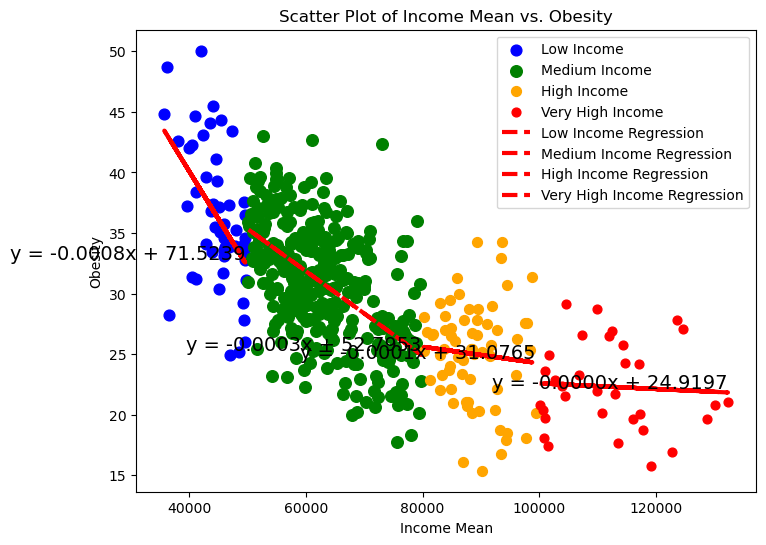

In [19]:
#The plot above contains scatterplots for each category the linear regression line and equation. 
# Scatter plots
plt.figure(figsize=(8, 6))
plt.scatter(filtered_Low_copy.Income_Mean, filtered_Low_copy.Obesity, label='Low Income', color='blue', marker='o', s=60)
plt.scatter(filtered_Medium_copy.Income_Mean, filtered_Medium_copy.Obesity, label='Medium Income', color='green', marker='o', s=70)
plt.scatter(filtered_High_copy.Income_Mean, filtered_High_copy.Obesity, label='High Income', color='orange', marker='o', s=50)
plt.scatter(filtered_VHigh_copy.Income_Mean, filtered_VHigh_copy.Obesity, label='Very High Income', color='red', marker='o', s=40)

# Regression lines and equations
for df, label, color in zip([filtered_Low_copy, filtered_Medium_copy, filtered_High_copy, filtered_VHigh_copy],
                            ['Low Income', 'Medium Income', 'High Income', 'Very High Income'],
                            ['blue', 'green', 'orange', 'red']):
    # Regression model
    coefficients = np.polyfit(df.Income_Mean, df.Obesity, 1)
    
    # Slope and intercept
    slope, intercept = coefficients

    # Plotting the regression line
    plt.plot(df.Income_Mean, slope * df.Income_Mean + intercept, label=f'{label} Regression', color='red', linestyle='--', linewidth=3)

    #Regression equation as text annotation
    equation_text = f'y = {slope:.4f}x + {intercept:.4f}'
    plt.text(df.Income_Mean.max(), slope * df.Income_Mean.max() + intercept, equation_text, color='black', ha='right', va='bottom', fontsize=14)

# labels and legend
plt.xlabel('Income Mean')
plt.ylabel('Obesity')
plt.title('Scatter Plot of Income Mean vs. Obesity')
plt.legend()
plt.savefig('Scatter Plot of Income Mean vs. Obesity.png')
plt.show()


#### Above is the scatter plot of all the Income and Mean Data, linear regression line and equation.

In [20]:
Income_Analysis_df_r = Income_Analysis_df.copy(deep = True)
Income_Analysis_df_r.rename(columns ={'Income Mean' :'Income_Mean'}, inplace = True)

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Linear Regression Equation: y = -0.00x + 45.32
correlation_coefficient -0.6726494972683474


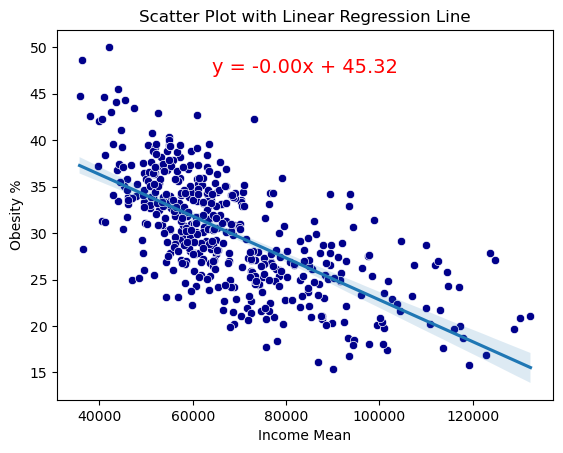

In [21]:
import seaborn as sns
ax1 = sns.scatterplot(data=Income_Analysis_df, x='Income Mean', y='Obesity', color='DarkBlue')
# Linear regression line with seaborn
sns.regplot(data=Income_Analysis_df, x='Income Mean', y='Obesity', scatter=False, ax=ax1)
# Calculation of linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(Income_Analysis_df['Income Mean'], Income_Analysis_df['Obesity'])
# linear regression equation
line_eq = f'y = {slope:.2f}x + {intercept:.2f}'
print(f"Linear Regression Equation: {line_eq}")

plt.text(0.5, 0.9, line_eq, ha='center', va='center', fontsize=14, color="red", transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
plt.title('Scatter Plot with Linear Regression Line')
plt.xlabel('Income Mean')
plt.ylabel('Obesity %')

correlation_coefficient = Income_Analysis_df_r['Income_Mean'].corr(Income_Analysis_df_r['Obesity'])
print('correlation_coefficient' , correlation_coefficient)                                                                
plt.savefig('Scatter Plot with Linear Regression Line.png')                                   
plt.show()


#### Scatter Plot , linear regression and equation for northern_hemis_df.

In [22]:
northern_hemi_df = Income_Analysis_df.loc[pd.to_numeric(Income_Analysis_df["Lat"]).astype(float) > 0, :]
northern_hemi_df.head()

,City,Income Mean,Lat,Lon,Obesity
0,Abilene,51441.866667,32.450916,-99.748149,33.838462
1,Akron,53194.675000,41.076997,-81.521454,38.142647
2,Alameda,89726.375000,37.764098,-122.260090,20.338889
3,Albany,52808.971429,37.219589,-78.884677,35.403636
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050


In [23]:
# The Latitude is less than 0, so there is no Data for this category.

southern_hemi_df = Income_Analysis_df.loc[pd.to_numeric(Income_Analysis_df["Lat"]).astype(float) < 0, :]
southern_hemi_df.head()


,City,Income Mean,Lat,Lon,Obesity


##### From the graph and the lenear regression line seems to have no correlation.

The r-squared is: -0.00626200969911631


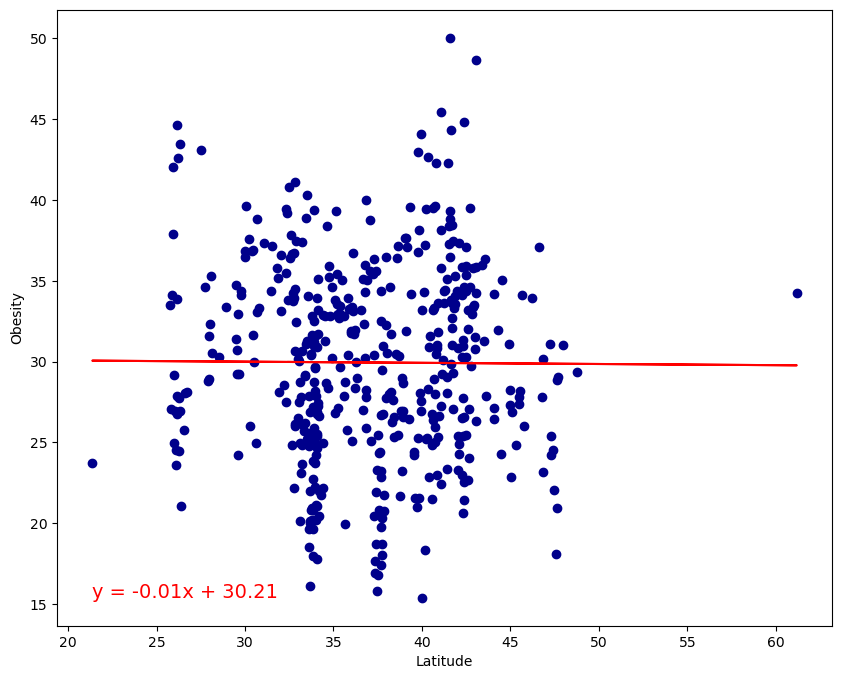

In [24]:
plt.figure(figsize=(10, 8))
x_values = pd.to_numeric(northern_hemi_df['Lat']).astype(float)
y_values = pd.to_numeric(northern_hemi_df['Obesity']).astype(float)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# Linear regression on Northern Hemisphere
plt.scatter(x_values,y_values, color='DarkBlue')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15) #color="Blue")
plt.xlabel('Latitude')
plt.ylabel('Obesity')
equation_position = (min(x_values), min(y_values))
plt.text(equation_position[0], equation_position[1], line_eq, fontsize=14, color="red", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
print(f"The r-squared is: {rvalue}")
plt.show()

# ----------------------------------------------------------------------------------

#### This section does the categorization by using labels and bins, because it helps to built the map.

In [25]:
# Setting the 4 ranges same as in the first session.

income_bins = [0, 50000, 80000,100000, 1500000]
labels = ["Low (<50000)", "Medium (50000-80000)", "High (80000-100000)","VeryHigh (>100000)"]
Income_Analysis_df["Income_Mean_Range"] = pd.cut(Income_Analysis_df['Income Mean'], bins=income_bins, labels=labels)
Income_Range_Analysis_df =Income_Analysis_df.copy(deep = True)
Income_Range_Analysis_df.head()

,City,Income Mean,Lat,Lon,Obesity,Income_Mean_Range
0,Abilene,51441.866667,32.450916,-99.748149,33.838462,Medium (50000-80000)
1,Akron,53194.675000,41.076997,-81.521454,38.142647,Medium (50000-80000)
2,Alameda,89726.375000,37.764098,-122.260090,20.338889,High (80000-100000)
3,Albany,52808.971429,37.219589,-78.884677,35.403636,Medium (50000-80000)
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050,Medium (50000-80000)


In [26]:
#Replacing labels = ["Low (<50000)", "Medium (50000-80000)", "High (80000-100000)","VeryHigh (>100000)"] 
#with labels = ["Low_Income", "Medium_Income", "High_Income", "VeryHigh_Income"] because the parentheses creating errors so its more easy replacing them with text/string.
income_bins = [0, 50000, 80000,100000, 1500000]
labels = ["Low_Income", "Medium_Income", "High_Income", "VeryHigh_Income"]
# Creatting a new column with income categories in your DataFrame
Income_Analysis_df["Income_Mean_Range"] = pd.cut(Income_Analysis_df['Income Mean'], bins=income_bins, labels=labels)
Income_Range_Analysis_df = Income_Analysis_df.copy(deep=True)
# Round to two decimal places
Income_Range_Analysis_df['Income Mean'] = Income_Range_Analysis_df['Income Mean'].round()
Income_Range_Analysis_df['Obesity'] = Income_Range_Analysis_df['Obesity'].round()
Income_Range_Analysis_df.head()

,City,Income Mean,Lat,Lon,Obesity,Income_Mean_Range
0,Abilene,51442.0,32.450916,-99.748149,34.0,Medium_Income
1,Akron,53195.0,41.076997,-81.521454,38.0,Medium_Income
2,Alameda,89726.0,37.764098,-122.260090,20.0,High_Income
3,Albany,52809.0,37.219589,-78.884677,35.0,Medium_Income
4,Albuquerque,63773.0,35.112121,-106.612063,27.0,Medium_Income


In [27]:
Income_Range_Analysis_df_map = Income_Range_Analysis_df.copy(deep = True)
#Income_Range_Analysis_df_map = Income_Range_Analysis_df_1.drop(['Income Mean', 'Obesity'], axis=1)
Income_Range_Analysis_df_map = Income_Range_Analysis_df_map.reset_index(drop=True)                                                            
Income_Range_Analysis_df_map.head()                                                                                                                         

,City,Income Mean,Lat,Lon,Obesity,Income_Mean_Range
0,Abilene,51442.0,32.450916,-99.748149,34.0,Medium_Income
1,Akron,53195.0,41.076997,-81.521454,38.0,Medium_Income
2,Alameda,89726.0,37.764098,-122.260090,20.0,High_Income
3,Albany,52809.0,37.219589,-78.884677,35.0,Medium_Income
4,Albuquerque,63773.0,35.112121,-106.612063,27.0,Medium_Income


In [28]:
import folium

# Calculating the map center
map_center = [Income_Range_Analysis_df_map['Lat'].mean(), Income_Range_Analysis_df_map['Lon'].mean()]

# Create a Folium map
my_map = folium.Map(location=map_center, zoom_start=4)

# Defining colors and labels for the legend
legend_colors = {'Medium_Income': 'blue', 'VeryHigh_Income': 'green', 'Low_Income': 'red', 'Other': 'black'}
legend_labels = {'Medium_Income': 'Medium Income', 'VeryHigh_Income': 'Very High Income', 'Low_Income': 'Low Income', 'Other': 'Other'}

# Adding markers for each city with different colors based on income range
for index, row in Income_Range_Analysis_df_map.iterrows():
    color = legend_colors.get(row['Income_Mean_Range'], 'black')
    popup_content = f'''
        <div style="font-size: 14px; text-align: center;">
            <b>City:</b> {row['City']}<br>
            <b>Latitude:</b> {row['Lat']}<br>
            <b>Longitude:</b> {row['Lon']}<br>
            <b>Income Range:</b> {row['Income_Mean_Range']}<br>
            <b>Income Mean:</b> {row['Income Mean']}<br>
            <b>Obesity:</b> {row['Obesity']}<br>
        </div>
    '''
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(my_map)

# Adding the legend to the map
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 160px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; <div style="width: 15px; height: 15px; background-color: blue; display: inline-block;"></div> {} <br>
     &nbsp; <div style="width: 15px; height: 15px; background-color: green; display: inline-block;"></div> {} <br>
     &nbsp; <div style="width: 15px; height: 15px; background-color: red; display: inline-block;"></div> {} <br>
     &nbsp; <div style="width: 15px; height: 15px; background-color: black; display: inline-block;"></div> {} <br>
     </div>
     '''.format(legend_labels['Medium_Income'], legend_labels['VeryHigh_Income'], 
                legend_labels['Low_Income'], legend_labels['Other'])

my_map.get_root().html.add_child(folium.Element(legend_html))


my_map.save('income_range_map.html')

my_map


# -----------------------------------------------------------------

## Additional Analysis and Plots

#### Plotting Income Data Analysis

In [29]:
New_Income_Range_Analysis_df = Income_Range_Analysis_df.copy(deep= True)

Low_Income = New_Income_Range_Analysis_df[New_Income_Range_Analysis_df["Income_Mean_Range"] == "Low_Income"]
Medium_Income = New_Income_Range_Analysis_df[New_Income_Range_Analysis_df["Income_Mean_Range"] == "Medium_Income"]
High_Income = New_Income_Range_Analysis_df[New_Income_Range_Analysis_df["Income_Mean_Range"] == "High_Income"]
VeryHigh_Income = New_Income_Range_Analysis_df[New_Income_Range_Analysis_df["Income_Mean_Range"] == "VeryHigh_Income"]

low_income_mean = Low_Income.groupby('City')['Obesity'].mean()
medium_income_mean = Medium_Income.groupby('City')['Obesity'].mean()
high_income_mean = High_Income.groupby('City')['Obesity'].mean()
very_high_income_mean = VeryHigh_Income.groupby('City')['Obesity'].mean()

New_Income_Range_Analysis_df = pd.DataFrame({
    'Low_Income': low_income_mean,
    'Medium_Income': medium_income_mean,
    'High_Income': high_income_mean,
    'VeryHigh_Income': very_high_income_mean,
})
#New_Income_Range_Analysis_df = New_Income_Range_Analysis_df.fillna(0)
# Display the DataFrame
New_Income_Range_Analysis_df.head()


,Low_Income,Medium_Income,High_Income,VeryHigh_Income
City,,,,
Abilene,NaN,34.0,NaN,NaN
Akron,NaN,38.0,NaN,NaN
Alameda,NaN,NaN,20.0,NaN
Albany,NaN,35.0,NaN,NaN
Albuquerque,NaN,27.0,NaN,NaN


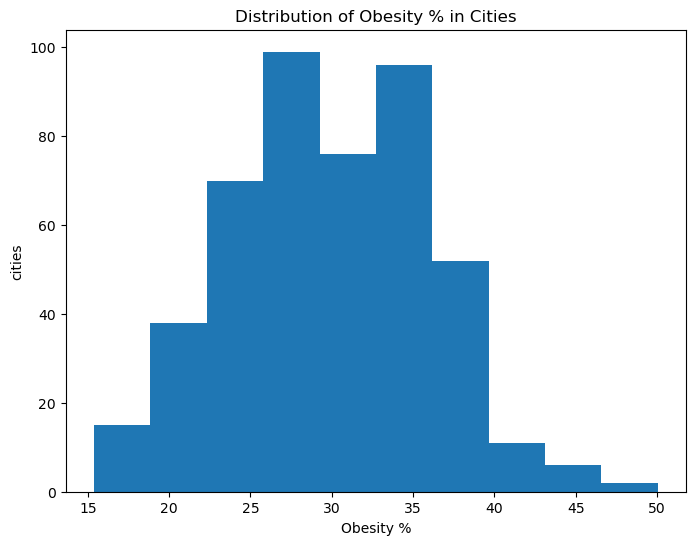

29.942828413742745
30.055882352941175
0    27.86
Name: Obesity, dtype: float64


In [30]:
plt.figure(figsize=(8, 6))
Plt_Income_Analysis_df = Income_Analysis_df.drop(['City', 'Lat', 'Lon'], axis=1)

plt.hist(Plt_Income_Analysis_df['Obesity'])
plt.xlabel('Obesity %')
plt.ylabel('cities')
plt.title('Distribution of Obesity % in Cities')
plt.show()

# Mean, median, and mode of the 'Obesity' column
print(Plt_Income_Analysis_df['Obesity'].mean())
print(Plt_Income_Analysis_df['Obesity'].median())
print(Plt_Income_Analysis_df['Obesity'].mode())


In [31]:
LowI= Income_Range_Analysis_df[Income_Range_Analysis_df.Income_Mean_Range == "Low_Income"]
LowIncome =LowI.copy(deep = True)
LowIncome.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)

MediumI = Income_Range_Analysis_df[Income_Range_Analysis_df.Income_Mean_Range == "Medium_Income"]
MediumIncome =MediumI.copy(deep = True)
MediumIncome.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)

HighI = Income_Range_Analysis_df[Income_Range_Analysis_df.Income_Mean_Range == "High_Income"]
HighIncome =HighI.copy(deep = True)
HighIncome.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)

VeryHighI = Income_Range_Analysis_df[Income_Range_Analysis_df.Income_Mean_Range == "VeryHigh_Income"]
VeryHighIncome =VeryHighI.copy(deep = True)
VeryHighIncome.rename(columns={'Income Mean': 'Income_Mean'}, inplace=True)


#LowIncome
#MediumIncome
#HighIncome
#VeryHighIncome

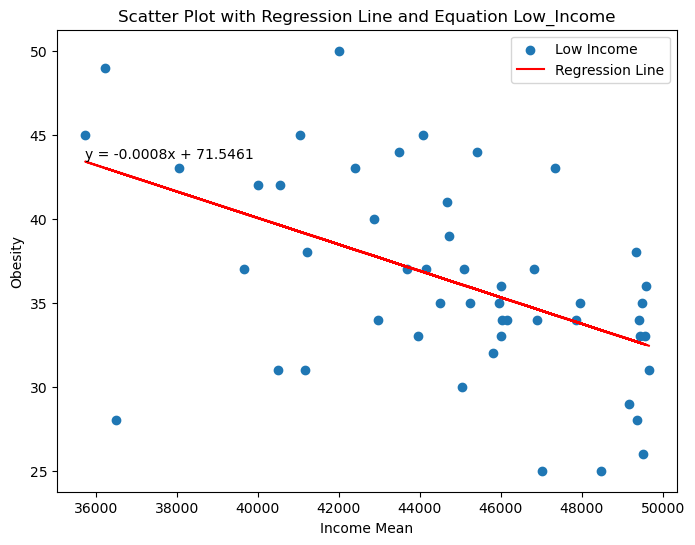

In [32]:
from sklearn.linear_model import LinearRegression
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(LowIncome.Income_Mean, LowIncome.Obesity, label='Low Income')

# Linear regression
model = LinearRegression()
model.fit(np.array(LowIncome.Income_Mean).reshape(-1, 1), LowIncome.Obesity)
slope = model.coef_[0]
intercept = model.intercept_

# Plot regression line
plt.plot(LowIncome.Income_Mean, model.predict(np.array(LowIncome.Income_Mean).reshape(-1, 1)), color='red', label='Regression Line')

# Equation as text annotation
equation_text = f'y = {slope:.4f}x + {intercept:.4f}'
plt.text(LowIncome.Income_Mean.min(), model.predict(np.array(LowIncome.Income_Mean.min()).reshape(-1, 1))[0],
         equation_text, color='black', ha='left', va='bottom', fontsize=10)
# labels and legend
plt.xlabel('Income Mean')
plt.ylabel('Obesity')
plt.title('Scatter Plot with Regression Line and Equation Low_Income')
plt.legend()

plt.show()


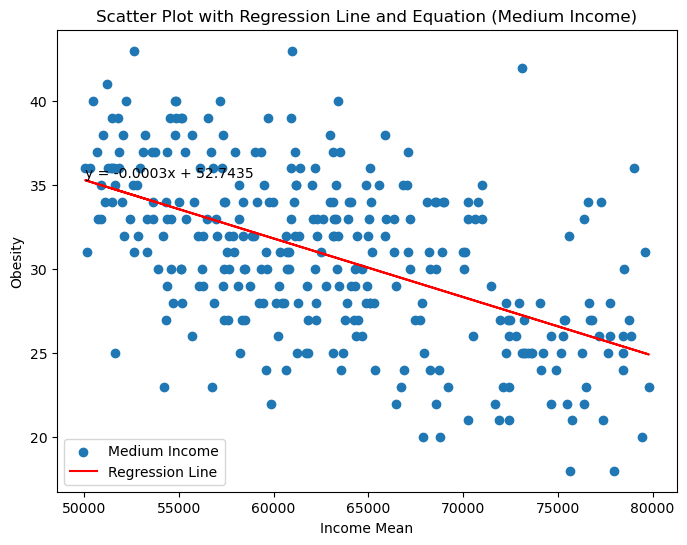

In [33]:

from sklearn.linear_model import LinearRegression
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(MediumIncome.Income_Mean, MediumIncome.Obesity, label='Medium Income')

# Linear regression
model = LinearRegression()
model.fit(np.array(MediumIncome.Income_Mean).reshape(-1, 1), MediumIncome.Obesity)
slope = model.coef_[0]
intercept = model.intercept_

# Plot regression line
plt.plot(MediumIncome.Income_Mean, model.predict(np.array(MediumIncome.Income_Mean).reshape(-1, 1)), color='red', label='Regression Line')

#Equation as text annotation
equation_text = f'y = {slope:.4f}x + {intercept:.4f}'
plt.text(MediumIncome.Income_Mean.min(), model.predict(np.array(MediumIncome.Income_Mean.min()).reshape(-1, 1))[0],
         equation_text, color='black', ha='left', va='bottom', fontsize=10)

# labels and legend
plt.xlabel('Income Mean')
plt.ylabel('Obesity')
plt.title('Scatter Plot with Regression Line and Equation (Medium Income)')
plt.legend()

plt.show()


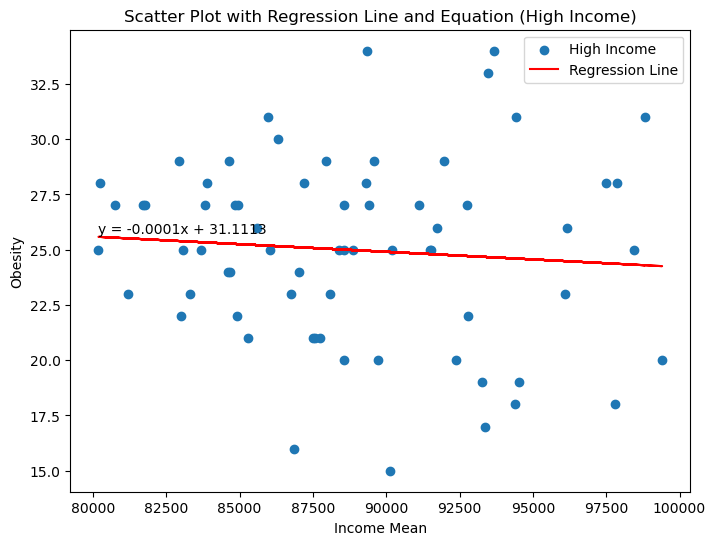

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(HighIncome.Income_Mean, HighIncome.Obesity, label='High Income')

# Linear regression
model = LinearRegression()
model.fit(np.array(HighIncome.Income_Mean).reshape(-1, 1), HighIncome.Obesity)
slope = model.coef_[0]
intercept = model.intercept_

# Plot regression line
plt.plot(HighIncome.Income_Mean, model.predict(np.array(HighIncome.Income_Mean).reshape(-1, 1)), color='red', label='Regression Line')

# Equation as text annotation
equation_text = f'y = {slope:.4f}x + {intercept:.4f}'
plt.text(HighIncome.Income_Mean.min(), model.predict(np.array(HighIncome.Income_Mean.min()).reshape(-1, 1))[0],
         equation_text, color='black', ha='left', va='bottom', fontsize=10)

#labels and legend
plt.xlabel('Income Mean')
plt.ylabel('Obesity')
plt.title('Scatter Plot with Regression Line and Equation (High Income)')
plt.legend()

plt.show()


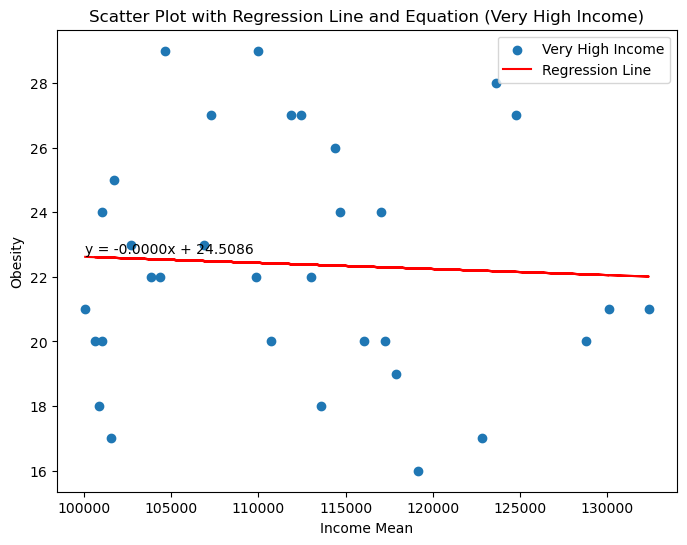

In [35]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(VeryHighIncome.Income_Mean, VeryHighIncome.Obesity, label='Very High Income')

# Linear regression
model = LinearRegression()
model.fit(np.array(VeryHighIncome.Income_Mean).reshape(-1, 1), VeryHighIncome.Obesity)
slope = model.coef_[0]
intercept = model.intercept_

#Plot regression line
plt.plot(VeryHighIncome.Income_Mean, model.predict(np.array(VeryHighIncome.Income_Mean).reshape(-1, 1)), color='red', label='Regression Line')

# Equation as text annotation
equation_text = f'y = {slope:.4f}x + {intercept:.4f}'
plt.text(VeryHighIncome.Income_Mean.min(), model.predict(np.array(VeryHighIncome.Income_Mean.min()).reshape(-1, 1))[0],
         equation_text, color='black', ha='left', va='bottom', fontsize=10)

# Labels and legend
plt.xlabel('Income Mean')
plt.ylabel('Obesity')
plt.title('Scatter Plot with Regression Line and Equation (Very High Income)')
plt.legend()

plt.show()


# __________________________________________________________________